<a href="https://colab.research.google.com/github/PFSV/bspl-ku.github.io/blob/main/bAbI_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.utils.data_utils import get_file

import collections
import itertools
import nltk
nltk.download()
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import tarfile
from functools import reduce

%matplotlib inline

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> Download
Command 'Download' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Ex

      Unzipping tokenizers/punkt.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [2]:
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')

tar = tarfile.open(path)

11755520/11745123 [==============================] - 0s 0us/step


In [3]:
def tokenize(sent):
    '''
    argument: a sentence string
    returns a list of tokens(words)
    '''
    return word_tokenize(sent)
 
def parse_stories(lines):
    '''
    - Parse stories provided in the bAbI tasks format
    - A story starts from line 1 to line 15. Every 3rd line,
      there is a question &amp;amp;amp;amp;amp; answer.
    - Function extracts sub-stories within a story and
      creates tuples
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            # reset story when line ID=1 (start of new story)
            story = []
        if '\t' in line:
            # this line is tab separated Q, A &amp;amp;amp;amp;amp; support fact ID
            q, a, supporting = line.split('\t')
            # tokenize the words of question
            q = tokenize(q)
            # Provide all the sub-stories till this question
            substory = [x for x in story if x]
            # A story ends and is appended to global story data-set
            data.append((substory, q, a))
            story.append('')
        else:
            # this line is a sentence of story
            sent = tokenize(line)
            story.append(sent)
    return data
 
def get_stories(f):
    '''
    argument: filename
    returns list of all stories in the argument data-set file
    '''
    # read the data file and parse 10k stories
    data = parse_stories(f.readlines())
    # lambda func to flatten the list of sentences into one list
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    # creating list of tuples for each story
    data = [(flatten(story), q, answer) for story, q, answer in data]
    return data

In [6]:
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
print('Extracting stories for the challenge: single_supporting_fact_10k')
# Extracting train stories
train_stories = get_stories(tar.extractfile(challenge.format('train')))
# Extracting test stories
test_stories = get_stories(tar.extractfile(challenge.format('test')))

Extracting stories for the challenge: single_supporting_fact_10k


In [7]:
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
train_stories[0]

Number of training stories: 10000
Number of test stories: 1000


(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.'],
 ['Where', 'is', 'Mary', '?'],
 'bathroom')

In [8]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    # story vector initialization
    X = []
    # query vector initialization
    Xq = []
    # answer vector intialization
    Y = []
    for story, query, answer in data:
        # creating list of story word indices
        x = [word_idx[w] for w in story]
        # creating list of query word indices
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        # creating label 1 for the answer word index
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

In [9]:
# creating vocabulary of words in train and test set
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])

# sorting the vocabulary
vocab = sorted(vocab)
 
# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
 
# calculate maximum length of story
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
 
# calculate maximum length of question/query
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))
 
# creating word to index dictionary
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
 
# creating index to word dictionary
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
 
# vectorize train story, query and answer sentences/word using vocab
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
# vectorize test story, query and answer sentences/word using vocab
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)

In [10]:
print('-------------------------')
print('Vocabulary:\n',vocab,"\n")
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-------------------------')

-------------------------
Vocabulary:
 ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'back', 'bathroom', 'bedroom', 'garden', 'hallway', 'is', 'journeyed', 'kitchen', 'moved', 'office', 'the', 'to', 'travelled', 'went'] 

Vocab size: 22 unique words
Story max length: 68 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-------------------------


In [11]:
# number of epochs to run
train_epochs = 100
# Training batch size
batch_size = 32
# Hidden embedding size
embed_size = 50
# number of nodes in LSTM layer
lstm_size = 64
# dropout rate
dropout_rate = 0.30

In [12]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))
 
print('Input sequence:', input_sequence)
print('Question:', question)
 
# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, embedding_dim)
 
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, query_maxlen)
 
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=query_maxlen))
question_encoder.add(Dropout(dropout_rate))
# output: (samples, query_maxlen, embedding_dim)
 
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)
 
# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
print(match.shape)
match = Activation('softmax')(match)
print('Match shape', match)
 
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)
print('Response shape', response)
 
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")
(None, 68, 4)
Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activati

In [13]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 68)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 50)     1100        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 4, 50)        1100        ['input_2[0][0]']                
                                                                                              

In [14]:
# start training the model
history = model.fit([inputs_train, queries_train], answers_train, 
                    batch_size=batch_size, 
                    epochs=train_epochs,
                    validation_data=([inputs_test, queries_test], answers_test))
 
# save model
model.save('model.h5')

Epoch 1/100
313/313 [==============================] - 11s 16ms/step - loss: 1.8866 - accuracy: 0.1683 - val_loss: 1.7948 - val_accuracy: 0.1670
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 1.6997 - accuracy: 0.2648 - val_loss: 1.6439 - val_accuracy: 0.2930
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 1.6449 - accuracy: 0.2998 - val_loss: 1.6606 - val_accuracy: 0.2970
Epoch 4/100
313/313 [==============================] - 4s 14ms/step - loss: 1.5952 - accuracy: 0.3522 - val_loss: 1.5343 - val_accuracy: 0.4190
Epoch 5/100
313/313 [==============================] - 5s 15ms/step - loss: 1.5111 - accuracy: 0.4127 - val_loss: 1.4771 - val_accuracy: 0.4110
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 1.4668 - accuracy: 0.4356 - val_loss: 1.4058 - val_accuracy: 0.4840
Epoch 7/100
313/313 [==============================] - 4s 14ms/step - loss: 1.4207 - accuracy: 0.4639 - val_loss: 1.3596 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


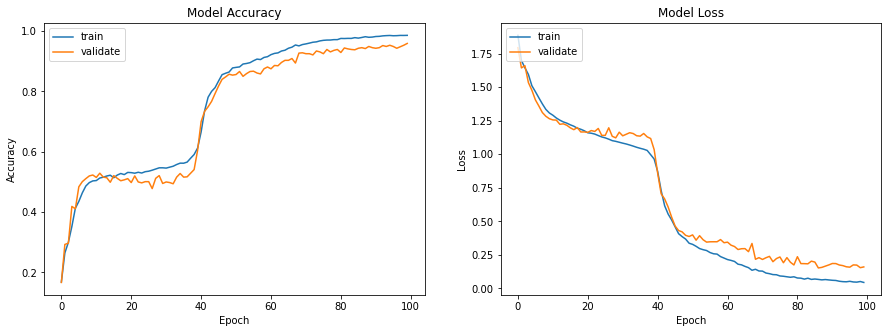

In [15]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [16]:
for i in range(0,10):
    current_inp = test_stories[i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
    current_prediction = idx_word[np.argmax(current_prediction)]
    print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
    print("--------------------------------------------------------------")

John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: hallway | Ground Truth: hallway
--------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . Where is Mary ? | Prediction: bathroom | Ground Truth: bathroom
--------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Where is Sandra ? | Prediction: kitchen | Ground Truth: kitchen
--------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Sandra travelled to the hallway . John went to the